# Fitting Notebook
This notebook shows step by step how to use the Fitting module provided in the WaterClass package

In [1]:
%load_ext autoreload
%autoreload 2

# add the parent directory in the path to import 
import sys
sys.path.append('../')

import plotly
import plotly.express as px
import sklearn

from WaterClassification.Fitting import *
from WaterClassification.common import *
from WaterClassification.Radiometry import RadiometryDB


## Fit Class

In [5]:
Fit?

Init signature: Fit(func, x, y, metrics=None, optimize_metric=None)
Docstring:     
Base class of the fitting module. It stores ONE fit with original data and fitting parameters.

There are some available functions ['linear', 'expo', 'power', 'nechad'] but other functions can be
passed as parameter to the fitting

Different metrics can be used to minimize the error ['r2', 'rmse', 'rmsle', 'SSE']
Original data and fitted parameters keeps stored in the class.
Init docstring:
Fits a model (function) to a set of data (x, y), minimizing the optimize metric.
Stores the parameters and the errors as a dictionary.
:param func: math model y = f(x). Signature should be func_name(x, *params) -> y
It can also be a string from the list: ['linear', 'expo', 'power', 'nechad']
:param x: independent variable
:param y: targets or dependent variable
:param metrics: The metrics to be calculated after fitting. If none, use BaseFit.available_metrics
:param optimize_metric: If informed, the algo will use the 

### Create a synthetic regression problem

In [6]:
x, y = sklearn.datasets.make_regression(n_samples=100, n_features=2, random_state=0)

# shift to start at (0,0) and avoid negatives
x = x - x.min()
y = y - y.min()

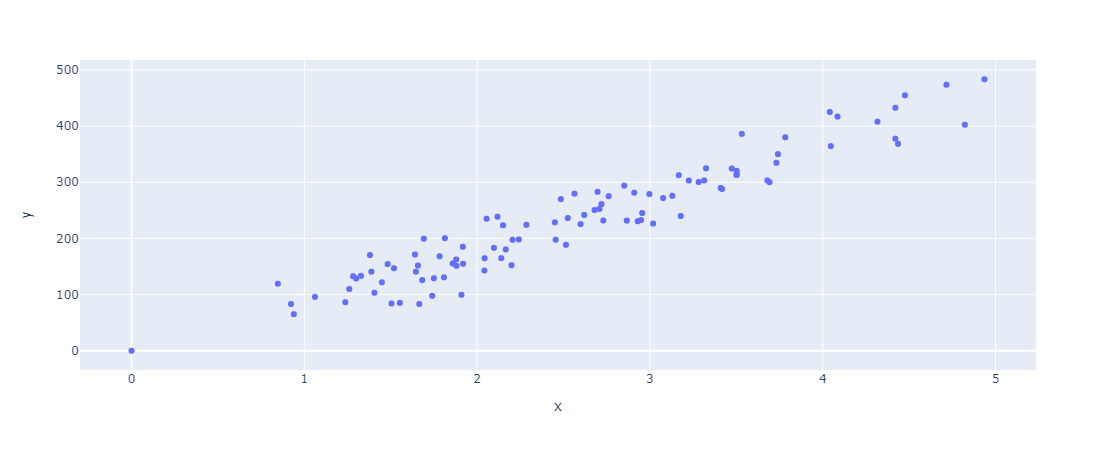

In [7]:
px.scatter(x=x[:, 1], y=y)

### Fitting one function

In [8]:
fit = Fit(Functions.linear, x=x[:, 1], y=y)
fit

Linear - qty: 100 | R^2: 0.9154 MSE: 880.2047 RMSE: 29.6682 RMSLE: 0.1725 SSE: 88020.4698 

In [9]:
# keep in mind that the fit_params has also other members like all the used Xs, Ys and Y_hats
fit.summary()

{'func': Linear,
 'band': None,
 R^2: 0.9154,
 MSE: 880.2047,
 RMSE: 29.6682,
 RMSLE: 0.1725,
 SSE: 88020.4698,
 'params': array([ 95.49654704, -13.14506397]),
 'qty': 100}

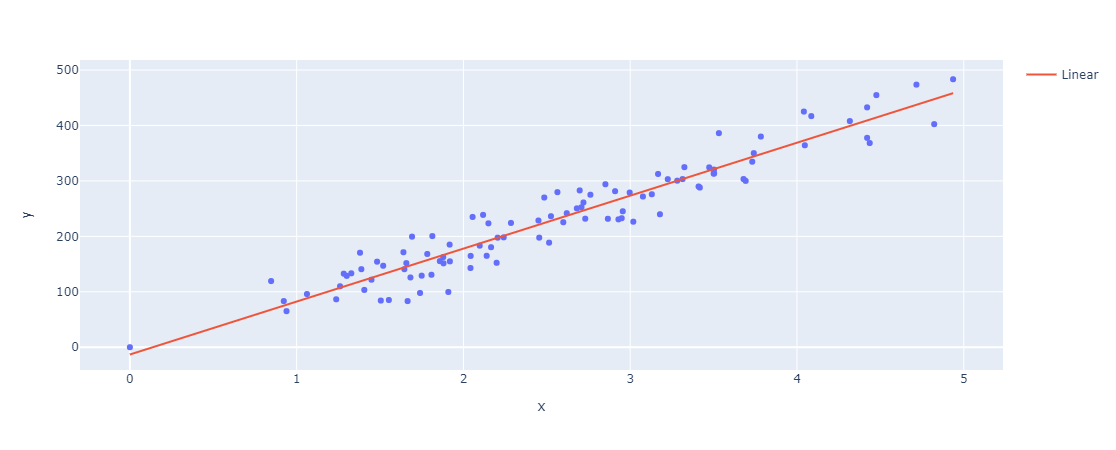

In [10]:
fit.plot_fit()

## Use Dataframe Values
It is possible to pass `x` and `y` as Pandas.Series objects (or numpy arrays). To exemplify, we are going to load a dataframe with reflectance values.

### Load Data as Dataframe

In [ ]:
from WaterClassification.Radiometry import RadiometryDB

db = RadiometryDB(r'D:\OneDrive - Agência Nacional de Águas\Data\GET-RadiometryDB')
db.load_radiometries(r_types=['Rrs'], qry="Area == 'Madeira'" )
df = db.rdmtries['Rrs']

In [12]:
fit = Fit(Functions.nechad, x=df['865'], y=df['SPM'])
fit

Nechad - qty: 185 | R^2: 0.5456 MSE: 42707.8651 RMSE: 206.6588 RMSLE: 0.9619 SSE: 7900955.0357 

### Compare to other functions
During the plot, it is possible to pass other functions to be plotted in the same graph. <br>
Besides the function, it is necessary to pass the parameters... more than one can be passed.

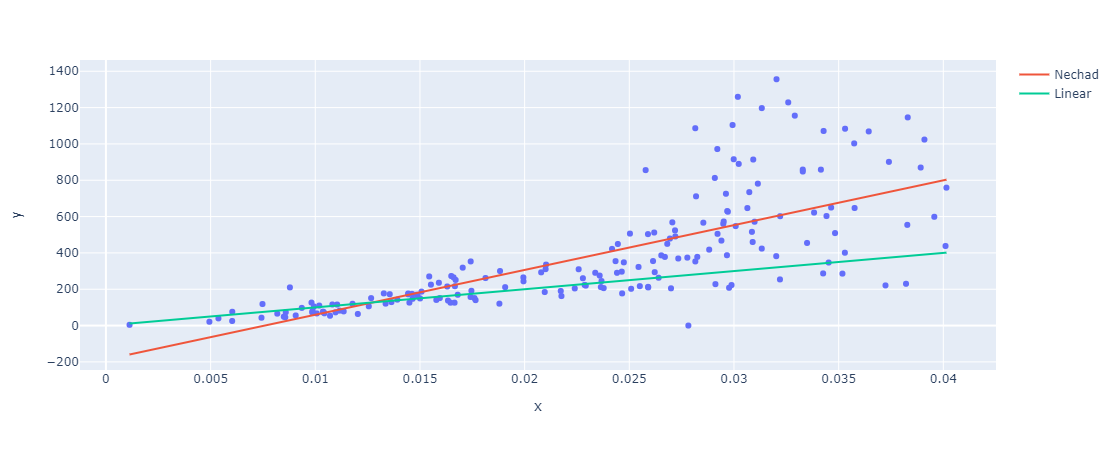

In [13]:
fit.plot_fit(new_funcs=Functions.linear, new_params=(1e4, 0))

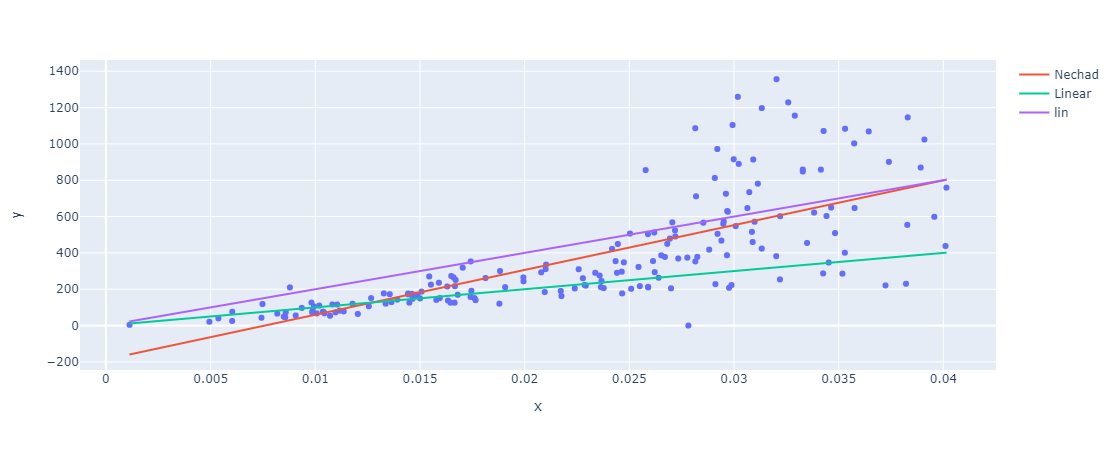

In [14]:
# And even combine built-in functions with new functions
def lin(x, a, b):
    return a * x + b

fig = fit.plot_fit(new_funcs=[Functions.linear, lin], new_params=[(1e4, 0), (2e4, 0)])
fig

## Dataframe Fitting
To fit data to values in dataframe columns, it is possible to use `DfFit` class and pass the names of the columns

In [15]:
dfit = DfFit(df, Functions.nechad, expr_x='865', expr_y='SPM')
dfit

Band 865 Nechad - qty: 185 | R^2: 0.5456 MSE: 42707.8651 RMSE: 206.6588 RMSLE: 0.9619 SSE: 7900955.0357 

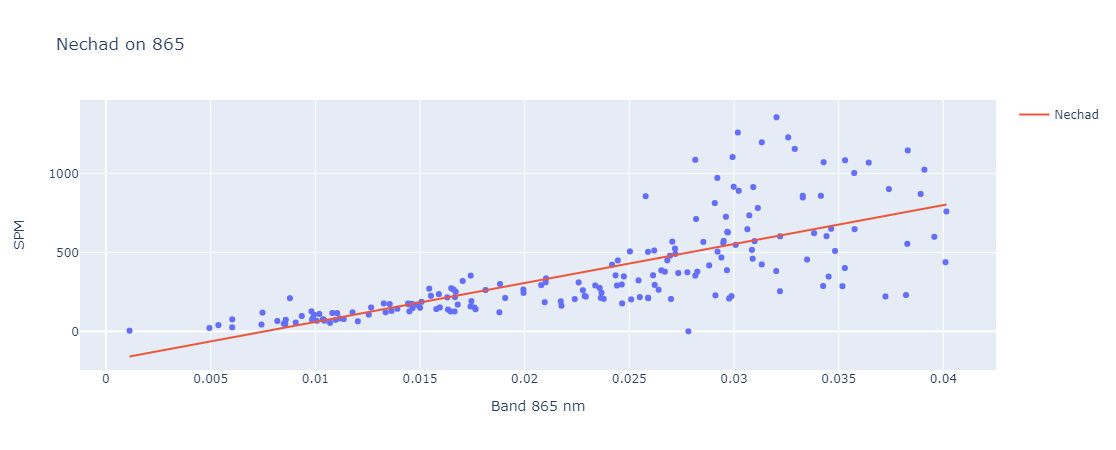

In [16]:
dfit.plot_fit()

## Expression support
The DfFit class supports the use of simple mathematic expressions to combine the features (columns). <br>
This way, it is not mandatory to create additional columns in the dataframe to represent some combinations. <br>
The function that parses a mathematical formula and process it in the columns is called `parse_expr_df`<br>
This will be explained in the following example:

In [17]:
DfFit.parse_expr_df(df, '(b560 + b865)/SPM')[:5]

Id
19    0.000121
20    0.000148
21    0.000410
22    0.000062
23    0.000174
Name: (b560 + b865)/SPM, dtype: float64

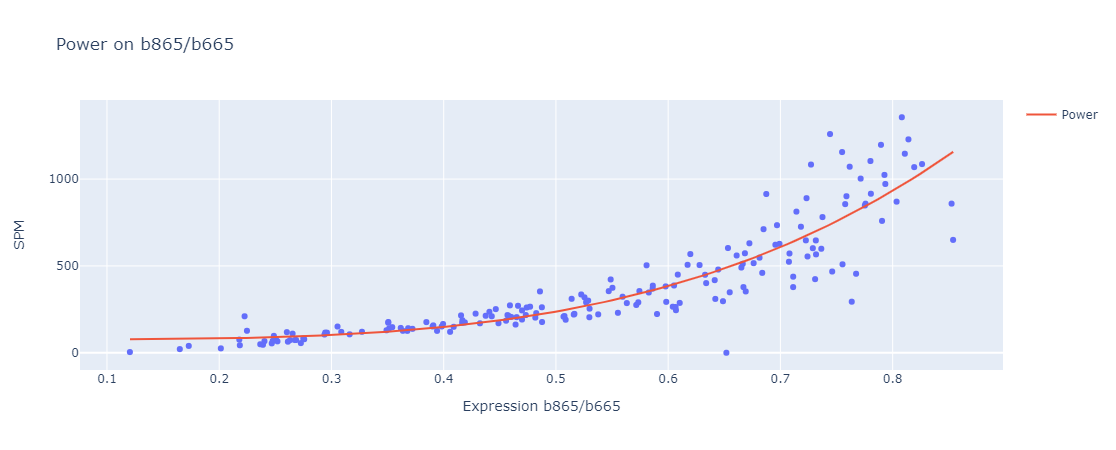

In [18]:
dfit1 = DfFit(df, Functions.power, expr_x='b865/b665', expr_y='SPM')
dfit1.plot_fit()

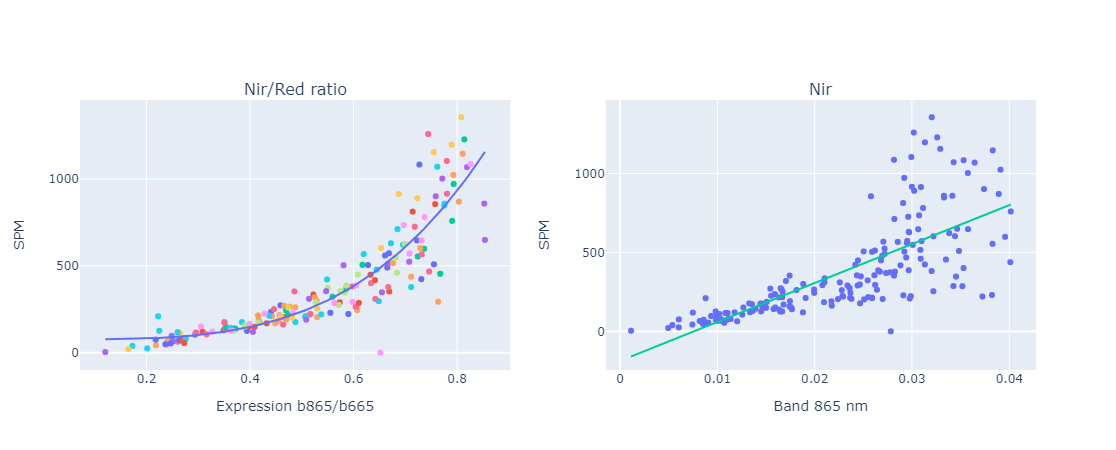

In [19]:
# Thanks to the multiple plot feature, we can compare the graphs of various fits effortlessly, for example
dfit2 = DfFit(df, Functions.nechad, expr_x='865', expr_y='SPM')

fig = plotly.subplots.make_subplots(rows=1, cols=2, subplot_titles=('Nir/Red ratio', 'Nir'))
dfit1.plot_fit(fig=fig, position=(1, 1), color='Station')
dfit2.plot_fit(fig=fig, position=(1, 2), update_layout={'showlegend':False})
fig

## Multiple Fitting
The objective of Multiple Fitting is to fit several functions and bands/expressions at once and get the results as a dataframe.

In [20]:
MultiFit?

Init signature:
MultiFit(
    df,
    lst_expr_x,
    funcs,
    expr_y='SPM',
    metrics=None,
    metric=RMSLE,
    n_cpus=None,
    pool=None,
    optimize_metric=False,
)
Docstring:     
Uses parallel processing to fit several functions and several independent variables (lst_expr_x) to the
dependent variable (expr_y) and return a dataframe with the results. Each fit is stored in the .fits list
Init docstring:
Performs several DfFits and save the results to get best results.
:param df: Dataframe with data to be fitted
:param lst_expr_x: columns/expressions to be tested
:param funcs: list of functions to be tested
:param expr_y: independent variable
:param metric: the metric to optimized
:param n_cpus: Number of CPUs to use in the processing. If None, no parallel processing
:param pool: existing pool to process the results. If None, a new pool is created
:param optimize_metric: If True, go thorough a second step minimizing the loss function of the metric
File:           d:\onedrive 

In [21]:
#example: Fit a linear and a power function using Nir or Nir/Red as independent variables
mfit = MultiFit(df, ['865', 'b865/b665'], [Functions.linear, Functions.power], expr_y='SPM')
mfit

Multifit class with 4 fits on variable (SPM): df with 185 rows, bands:['865', 'b865/b665'] funcs[Linear, Power] 

In [22]:
mfit.fits

[Band b865/b665 Power - qty: 185 | R^2: 0.8117 MSE: 17693.773 RMSE: 133.0179 RMSLE: 0.5811 SSE: 3273348.0006 ,
 Band 865 Linear - qty: 185 | R^2: 0.5456 MSE: 42707.8636 RMSE: 206.6588 RMSLE: 0.9619 SSE: 7900954.7592 ,
 Band b865/b665 Linear - qty: 185 | R^2: 0.7112 MSE: 27140.8068 RMSE: 164.7447 RMSLE: 1.528 SSE: 5021049.2553 ,
 Band 865 Power - qty: 185 | Empty fitting]

In [23]:
mfit.best_fit

Band b865/b665 Power - qty: 185 | R^2: 0.8117 MSE: 17693.773 RMSE: 133.0179 RMSLE: 0.5811 SSE: 3273348.0006 

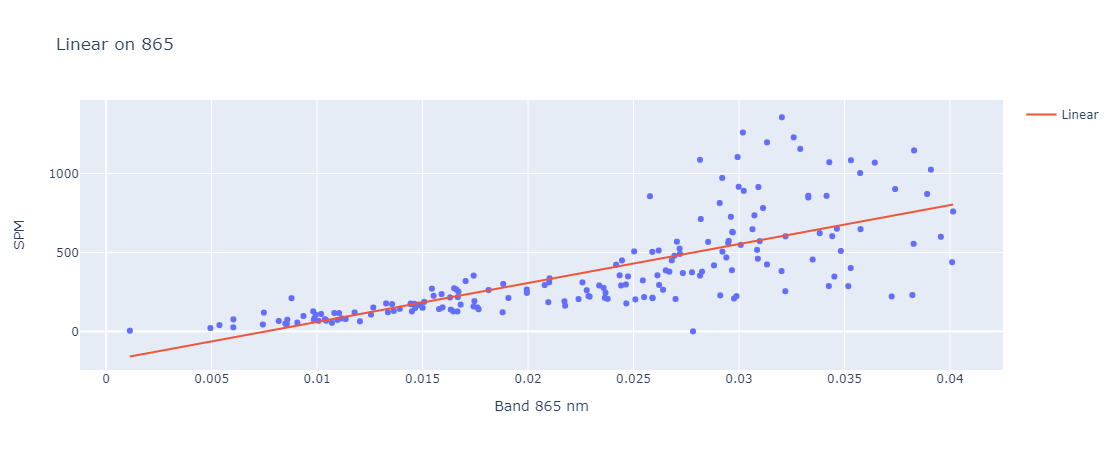

In [24]:
fig = mfit.get_fit(Functions.linear, '865').plot_fit()
fig

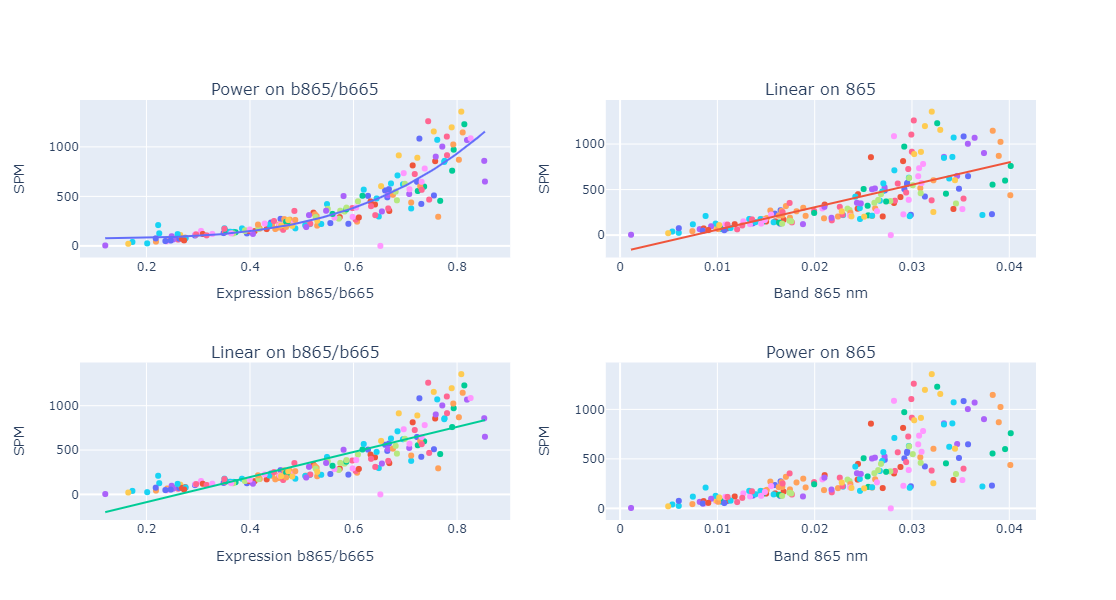

In [25]:
mfit.plot_best_fits(cols=2, base_height=300, color='Station', update_layout={'showlegend': False})

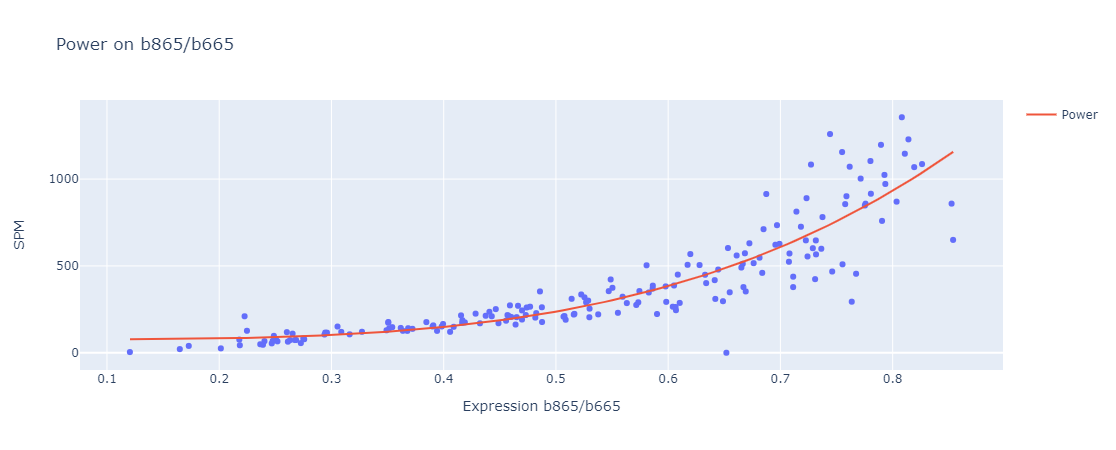

In [26]:
mfit.plot_best_fit()

It is also possible to select specific fits to be plotted, by passing function and band in a list of tuples. For example:

In [ ]:
mfit.plot_fits(plots=[('linear', '865'), (Functions.power, 'b865/b665')], cols=2, color='SPM')

## Group Fitting
Group by the unique values of a column in the dataframe. Fit one MultiFit object for each group. <br>
We need to pass a column of the dataframe that represent the groups. As we need some amount of data to perform the fit, we also set a threshold to inform the minimum number of points to be fitted.<br>
To exemplify how it works, we will load the dataframe and use the Basin/Area as the group by column:

In [2]:
db = RadiometryDB(r'D:\OneDrive - Agência Nacional de Águas\Data\GET-RadiometryDB')

db.load_radiometries(r_types=['Rrs'], qry="Status != 'Deleted' and Status != 'Suspicious'" )
df = db.rdmtries['Rrs']

Radiometries ['Rrs'] loaded in dictionary .rdmtries


### Parallel processing
The GroupFit, as well as the MultiFit classes support Parallel processing. It's jus need to inform the number of cpus, or pass a Pathos pool so it can perform all the fitting quicker.

In [29]:
db = RadiometryDB(r'D:\OneDrive - Agência Nacional de Águas\Data\GET-RadiometryDB')

db.load_radiometries(r_types=['Rrs'], qry="SPM > 0 and Status != 'Deleted'" )
df = db.rdmtries['Rrs']

Radiometries ['Rrs'] loaded in dictionary .rdmtries


In [35]:
# To test, we will get the best fit by river/basin and calculate the overall result
%time gfit = GroupFit(df, s2bands, BaseFit.available_funcs, 'Area', n_cpus=6, ignore_none=True, thresh=100, optimize_metric=True)
gfit

Fitting group=Descoberto
Fitting group=Indaia
Fitting group=Madeira
Fitting group=Paranapanema
Fitting group=Paranoa
Fitting group=Paraopeba
Fitting group=Purus
Fitting group=Sao_Francisco
Fitting group=Solimoes_Amazonas
Fitting group=Maroni
Fitting group=Saut_Hermina
Fitting group=Oiapoque
Fitting group=Ica
Fitting group=Jutai
Fitting group=Jurua
Fitting group=Japura
Fitting group=Lago_Tefe
Fitting group=Negro
Fitting group=Bagre
Fitting group=Ucayali
Fitting group=Mekong
Fitting group=Solimoes_Varzea
Fitting group=Tapajos
Fitting group=Maranon
Fitting group=Napo
Fitting group=Javari
Wall time: 52.8 s


Grouped fitting with 15 groups: ['Indaia', 'Madeira', 'Paranapanema', 'Paranoa', 'Paraopeba', 'Purus', 'Sao_Francisco', 'Solimoes_Amazonas', 'Maroni', 'Saut_Hermina', 'Negro', 'Bagre', 'Ucayali', 'Mekong', 'Solimoes_Varzea']

In [36]:
gfit.summary()

func band     R^2         MSE      RMSE   RMSLE  \
Indaia                   Power  865  0.9350    476.1592   21.8211  0.1968   
Madeira                  Power  940  0.5890  39521.0500  198.7990  0.4374   
Paranapanema             Power  783  0.7772     31.1521    5.5814  0.5256   
Paranoa                  Power  740  0.7894      5.5450    2.3548  0.3978   
Paraopeba          Exponential  842  0.4872    286.7484   16.9336  0.3098   
Purus                    Power  705  0.8388   1699.6719   41.2271  0.3302   
Sao_Francisco            Power  865  0.8850    390.4911   19.7608  0.1731   
Solimoes_Amazonas        Power  842  0.6197   1766.6070   42.0310  0.3366   
Maroni             Exponential  705  0.8984      4.0588    2.0146  0.0633   
Saut_Hermina       Exponential  783  0.7549     51.1229    7.1500  0.3508   
Negro              Exponential  705  0.5867      9.7687    3.1255  0.6215   
Bagre                    Power  865  0.9107   3941.6945   62.7829  0.2010   
Ucayali            Exponential  940  0.4526  78432.0705  280.0573  0.3946   
Mekong                   Power  842  0.7560   2961.6291   54.4209  0.2738   
Solimoes_Varzea          Power  740  0.5946    127.5578   11.2941  0.3791   
overall                    NaN  NaN  0.8206  13548.0897  116.3963  0.4317   

                            SSE  \
Indaia             6.190070e+03   
Madeira            7.034747e+06   
Paranapanema       1.277234e+03   
Paranoa            5.323206e+02   
Paraopeba          4.014477e+03   
Purus              5.778884e+04   
Sao_Francisco      8.590805e+03   
Solimoes_Amazonas  1.713609e+05   
Maroni             1.177056e+02   
Saut_Hermina       2.505020e+03   
Negro              1.523912e+03   
Bagre              8.277559e+04   
Ucayali            4.313764e+06   
Mekong             4.146281e+04   
Solimoes_Varzea    5.995214e+03   
overall            1.173265e+07   

                                                              params  qty  
Indaia             [15370.531744298973, 1.1687134387287905, -0.43...   13  
Madeira            [82269.85911979522, 1.248545892083472, -7.2079...  178  
Paranapanema       [40521.553088543966, 1.5579617814341815, 1.500...   41  
Paranoa            [765.4697148997573, 0.7857170583785542, -0.139...   96  
Paraopeba                  [1378.6566557486158, -1372.6569944000876]   14  
Purus              [15140.829379471681, 1.7463517557196377, 4.350...   34  
Sao_Francisco      [15040.920103134766, 1.2297788299550994, 3.867...   22  
Solimoes_Amazonas  [33958.64441425196, 1.352300920266522, 15.9749...   97  
Maroni                        [578.386420466403, -577.9275671097834]   29  
Saut_Hermina               [1291.8953577760485, -1291.3896128037509]   49  
Negro                         [336.9932062107682, -336.463564992883]  156  
Bagre              [135092.7147631188, 1.9424843792277842, 10.998...   21  
Ucayali                     [17396.982687974447, -17132.44758854474]   55  
Mekong             [5995.8921272018615, 0.8932830428043184, -4.95...   14  
Solimoes_Varzea    [410.8464418654545, 0.5729150360701696, -4.130...   47  
overall                                                         None  866

In [37]:
gfit['Madeira'].best_fit

Band 940 Power - qty: 178 | R^2: 0.589 MSE: 39521.05 RMSE: 198.799 RMSLE: 0.4374 SSE: 7034746.9047 

In [38]:
gfit.sort_fits(BaseFit.rmse)
gfit.summary()

func band     R^2         MSE      RMSE   RMSLE  \
Indaia                   Power  783  0.9449    404.0888   20.1020  0.2276   
Madeira                  Power  940  0.5890  39521.0500  198.7990  0.4374   
Paranapanema            Nechad  783  0.7849     30.0781    5.4843  0.6022   
Paranoa                 Nechad  740  0.8041      5.1583    2.2712  0.4022   
Paraopeba          Exponential  842  0.4872    286.7484   16.9336  0.3098   
Purus                    Power  865  0.9360    675.0782   25.9823  0.4458   
Sao_Francisco           Nechad  865  0.8884    379.0601   19.4695  0.1790   
Solimoes_Amazonas       Nechad  865  0.6332   1704.1137   41.2809  0.3417   
Maroni             Exponential  705  0.8984      4.0588    2.0146  0.0633   
Saut_Hermina       Exponential  783  0.7549     51.1229    7.1500  0.3508   
Negro              Exponential  665  0.5958      9.5515    3.0906  0.6230   
Bagre                   Nechad  940  0.9281   3174.1133   56.3393  0.2988   
Ucayali            Exponential  940  0.4526  78432.0705  280.0573  0.3946   
Mekong             Exponential  865  0.8650   1638.5490   40.4790  0.2910   
Solimoes_Varzea          Power  740  0.5946    127.5578   11.2941  0.3791   
overall                    NaN  NaN  0.8218  13459.3555  116.0145  0.4435   

                            SSE  \
Indaia             5.253155e+03   
Madeira            7.034747e+06   
Paranapanema       1.233201e+03   
Paranoa            4.952014e+02   
Paraopeba          4.014477e+03   
Purus              2.295266e+04   
Sao_Francisco      8.339322e+03   
Solimoes_Amazonas  1.652990e+05   
Maroni             1.177056e+02   
Saut_Hermina       2.505020e+03   
Negro              1.490037e+03   
Bagre              6.665638e+04   
Ucayali            4.313764e+06   
Mekong             2.293969e+04   
Solimoes_Varzea    5.995214e+03   
overall            1.165580e+07   

                                                              params  qty  
Indaia             [15119.37701374909, 1.4038762974909031, 1.6203...   13  
Madeira            [82269.85911979522, 1.248545892083472, -7.2079...  178  
Paranapanema       [861.8469282345467, -1986415611687.6797, -0.82...   41  
Paranoa            [805.3931156002568, -0.24574775785215297, 0.48...   96  
Paraopeba                  [1378.6566557486158, -1372.6569944000876]   14  
Purus              [21566.809604452435, 1.3184917769573004, 4.388...   34  
Sao_Francisco      [2088.3085597715262, 5.976599346123134, -6.374...   22  
Solimoes_Amazonas  [3220.606709624677, 4.691935330013526, -0.5538...   97  
Maroni                        [578.386420466403, -577.9275671097834]   29  
Saut_Hermina               [1291.8953577760485, -1291.3896128037509]   49  
Negro                       [306.9991648307326, -306.34941618110713]  156  
Bagre              [6689.10966798425, 1.6582348642901765, -60.864...   21  
Ucayali                     [17396.982687974447, -17132.44758854474]   55  
Mekong                        [4680.766738754309, -4680.52204596183]   14  
Solimoes_Varzea    [410.8464418654545, 0.5729150360701696, -4.130...   47  
overall                                                         None  866

In [39]:
gfit.summary()

func band     R^2         MSE      RMSE   RMSLE  \
Indaia                   Power  783  0.9449    404.0888   20.1020  0.2276   
Madeira                  Power  940  0.5890  39521.0500  198.7990  0.4374   
Paranapanema            Nechad  783  0.7849     30.0781    5.4843  0.6022   
Paranoa                 Nechad  740  0.8041      5.1583    2.2712  0.4022   
Paraopeba          Exponential  842  0.4872    286.7484   16.9336  0.3098   
Purus                    Power  865  0.9360    675.0782   25.9823  0.4458   
Sao_Francisco           Nechad  865  0.8884    379.0601   19.4695  0.1790   
Solimoes_Amazonas       Nechad  865  0.6332   1704.1137   41.2809  0.3417   
Maroni             Exponential  705  0.8984      4.0588    2.0146  0.0633   
Saut_Hermina       Exponential  783  0.7549     51.1229    7.1500  0.3508   
Negro              Exponential  665  0.5958      9.5515    3.0906  0.6230   
Bagre                   Nechad  940  0.9281   3174.1133   56.3393  0.2988   
Ucayali            Exponential  940  0.4526  78432.0705  280.0573  0.3946   
Mekong             Exponential  865  0.8650   1638.5490   40.4790  0.2910   
Solimoes_Varzea          Power  740  0.5946    127.5578   11.2941  0.3791   
overall                    NaN  NaN  0.8218  13459.3555  116.0145  0.4435   

                            SSE  \
Indaia             5.253155e+03   
Madeira            7.034747e+06   
Paranapanema       1.233201e+03   
Paranoa            4.952014e+02   
Paraopeba          4.014477e+03   
Purus              2.295266e+04   
Sao_Francisco      8.339322e+03   
Solimoes_Amazonas  1.652990e+05   
Maroni             1.177056e+02   
Saut_Hermina       2.505020e+03   
Negro              1.490037e+03   
Bagre              6.665638e+04   
Ucayali            4.313764e+06   
Mekong             2.293969e+04   
Solimoes_Varzea    5.995214e+03   
overall            1.165580e+07   

                                                              params  qty  
Indaia             [15119.37701374909, 1.4038762974909031, 1.6203...   13  
Madeira            [82269.85911979522, 1.248545892083472, -7.2079...  178  
Paranapanema       [861.8469282345467, -1986415611687.6797, -0.82...   41  
Paranoa            [805.3931156002568, -0.24574775785215297, 0.48...   96  
Paraopeba                  [1378.6566557486158, -1372.6569944000876]   14  
Purus              [21566.809604452435, 1.3184917769573004, 4.388...   34  
Sao_Francisco      [2088.3085597715262, 5.976599346123134, -6.374...   22  
Solimoes_Amazonas  [3220.606709624677, 4.691935330013526, -0.5538...   97  
Maroni                        [578.386420466403, -577.9275671097834]   29  
Saut_Hermina               [1291.8953577760485, -1291.3896128037509]   49  
Negro                       [306.9991648307326, -306.34941618110713]  156  
Bagre              [6689.10966798425, 1.6582348642901765, -60.864...   21  
Ucayali                     [17396.982687974447, -17132.44758854474]   55  
Mekong                        [4680.766738754309, -4680.52204596183]   14  
Solimoes_Varzea    [410.8464418654545, 0.5729150360701696, -4.130...   47  
overall                                                         None  866

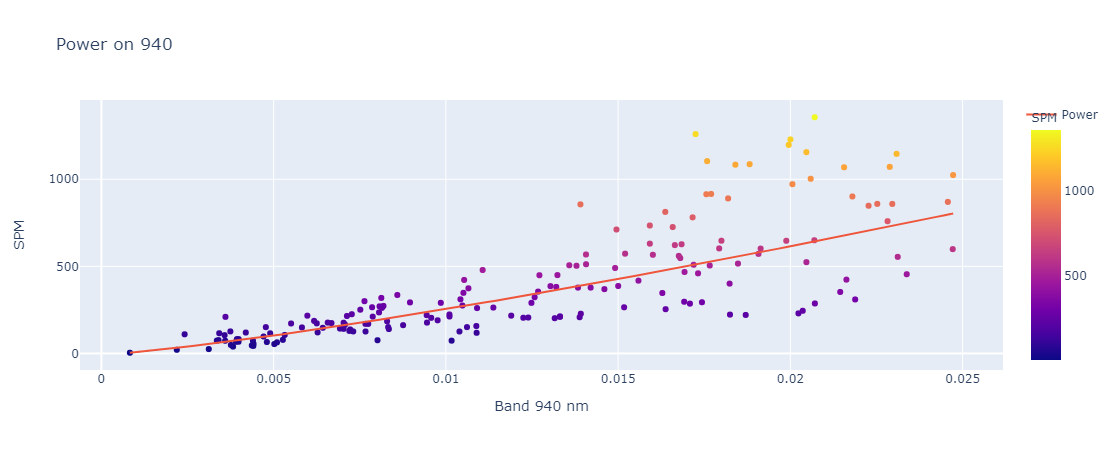

In [40]:
gfit.plot_group('Madeira', color='SPM')

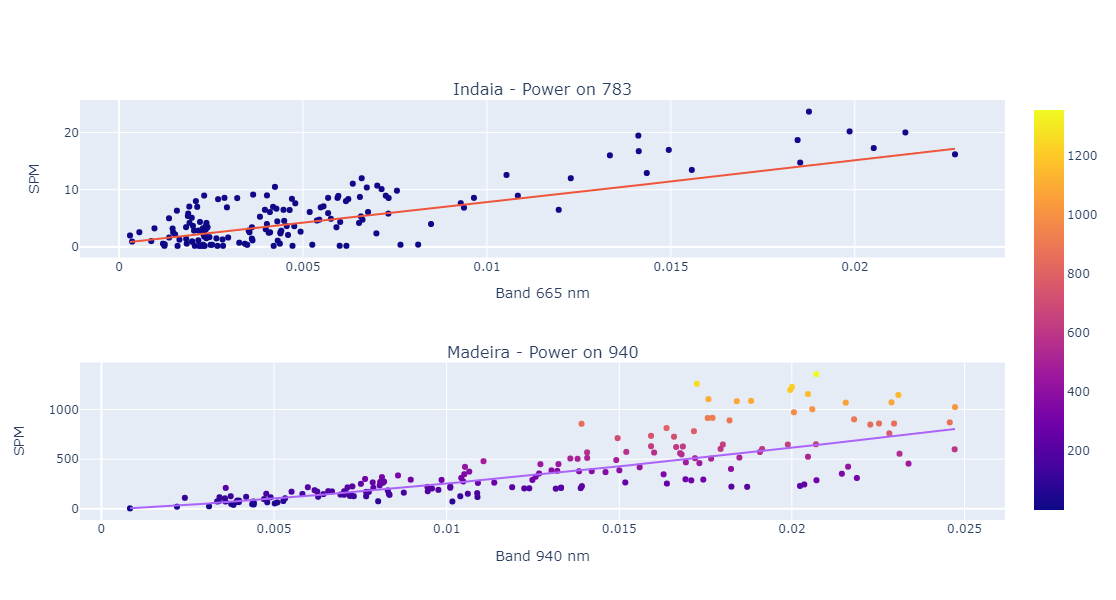

In [52]:
gfit.plot_groups(groups=['Negro', 'Madeira'], cols=1, color='SPM')

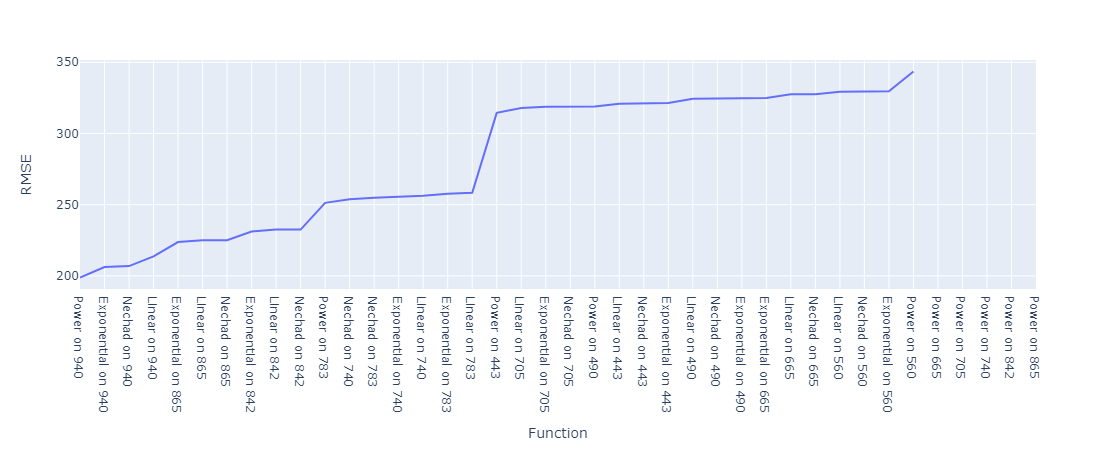

In [42]:
gfit['Madeira'].plot_metric()

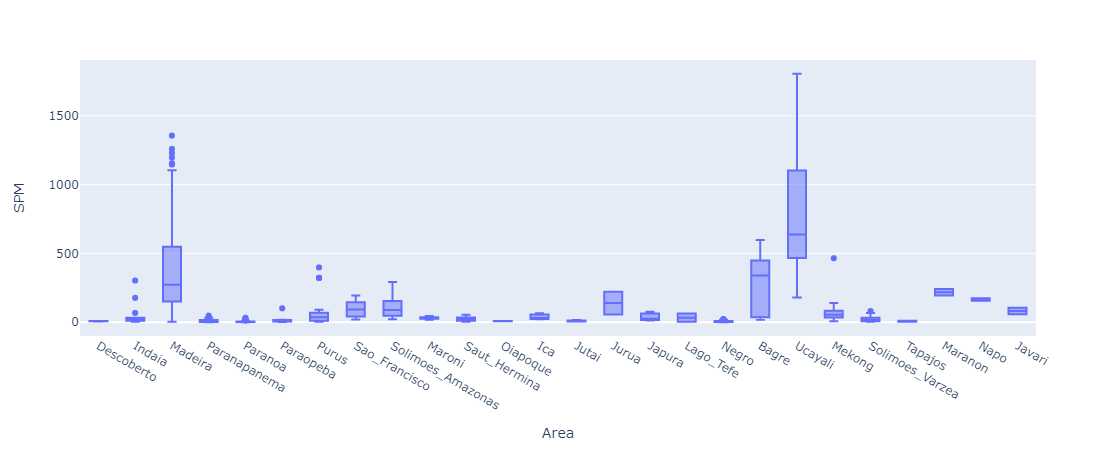

In [43]:
px.box(gfit.df, x='Area', y='SPM')

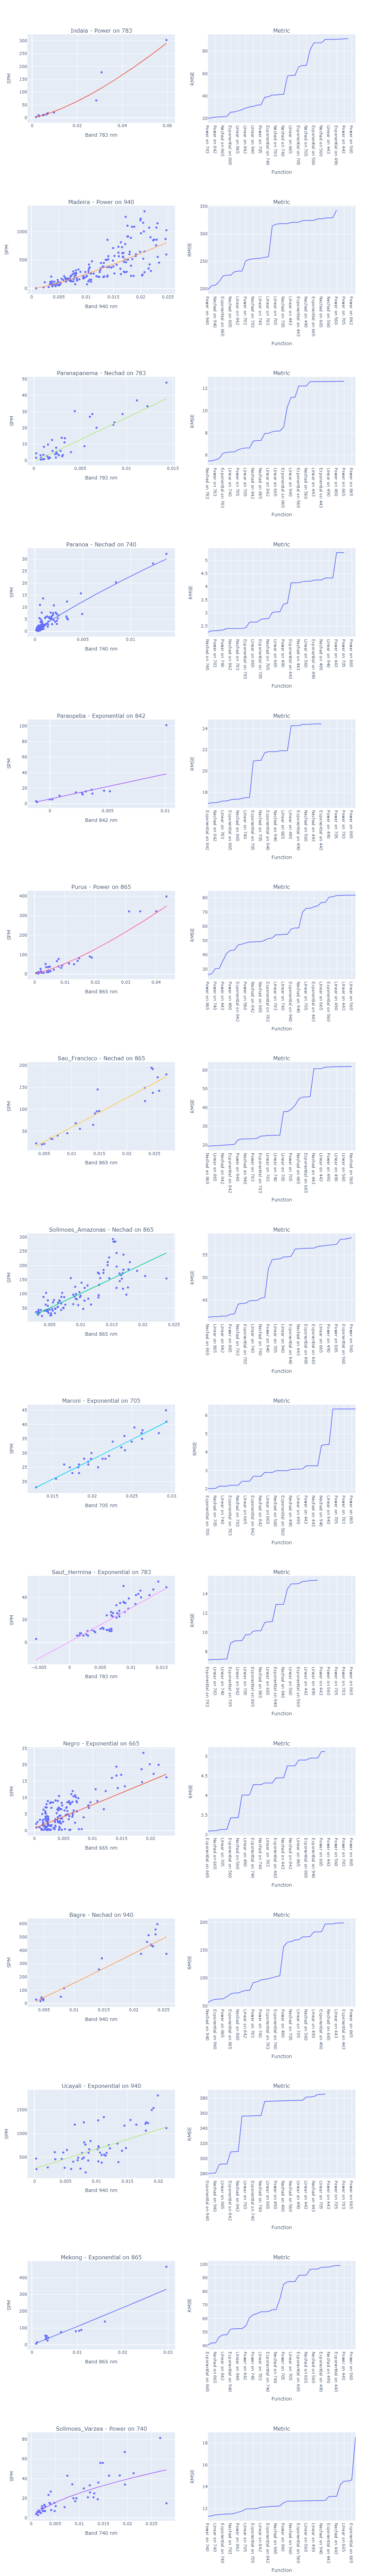

In [44]:
gfit.plot_groups_summary()

In [ ]:
gfit.summary()